In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
year = 'model'

Open data files and transform them into pandas dataframe

In [8]:
f = uproot.pandas.iterate("../outputs/"+year+"/*.root", "t")
data = pd.concat([j for j in f])[['label', 'be', 'm', 't']]

Sort values by label

In [9]:
data.sort_values(by='label', ascending=True, inplace=True);

Cut off incorrect beam energy and mass outside the window

In [12]:
data.query('be>0&m>450&m<550', inplace=True)
if not(year=='model'):
    data.query('t>-1', inplace=True)

Change index column

In [13]:
data.index = data.label
data.drop('label', axis=1, inplace=True)

Include luminosity file

In [15]:
lum = pd.read_csv('../inputs/'+year+'/lum', header=None, names=['label', 'lum'], index_col=['label'])

In [16]:
data.head()

,be,m,t
label,,,
550.0,550.0,497.302917,10
550.0,550.0,500.499481,10
550.0,550.0,494.340057,0
550.0,550.0,507.681244,-1
550.0,550.0,485.972534,1


In [17]:
lum.head()

,lum
label,
975.0,4113
687.5,3203
900.0,9170
1000.0,3361
787.5,8398


Join luminosity to data file

In [18]:
data = data.join(lum, how='inner')

See how much events in each point I have

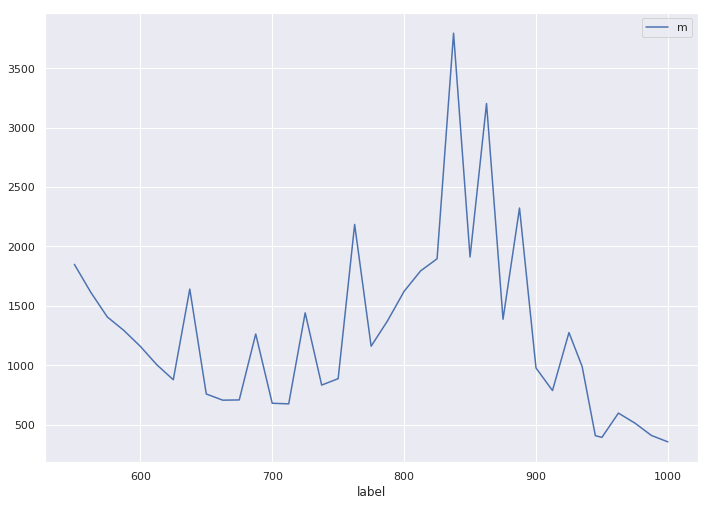

In [19]:
data.groupby('label').agg({'m':np.size}).plot()

In [23]:
data.groupby('label').agg({'m':np.size})

,m
label,
550.0,1848.0
562.5,1612.0
575.0,1405.0
587.5,1292.0
600.0,1158.0
612.5,1003.0
625.0,877.0
637.5,1640.0
650.0,757.0


Next stage: merge points with little data

In [21]:
cnct = [] #model
#cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935), ([942., 950., 971.], 960), 
#        ([981., 990, 1003.5],990)] #17 year
#cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
#cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year

In [22]:
data['label'] = data.index
for c in cnct:
    data.label.replace(c[0], c[1], inplace=True)
data.index = data.label
data.drop(['label'], axis=1, inplace=True)

OK, points have been merged

In [24]:
data.tail()

,be,m,t,lum
label,,,,
1000.0,1000.0,502.696716,10,3361
1000.0,1000.0,495.551575,0,3361
1000.0,1000.0,495.551575,0,3361
1000.0,1000.0,537.520752,1,3361
1000.0,1000.0,537.520752,1,3361


Get true luminosity for merged events

In [25]:
data['lume'] = data.be*data.lum

In [26]:
e_table = data.groupby('label').agg({'lume':[np.mean], 'lum':[np.mean], 'be':[np.max, np.min]})
e_table.columns = ['LE', 'L', 'Emax', 'Emin']

In [29]:
e_table.tail()

,Emean,dEmax,dEmin
label,,,
950.0,950.0,0.0,0.0
962.5,962.5,0.0,0.0
975.0,975.0,0.0,0.0
987.5,987.5,0.0,0.0
1000.0,1000.0,0.0,0.0


In [28]:
e_table['Emean'] = e_table['LE']/e_table['L']
e_table['dEmax'] = e_table['Emax'] - e_table['Emean']
e_table['dEmin'] = e_table['Emean'] - e_table['Emin']
e_table.drop(['Emax','Emin', 'LE', 'L'], axis=1, inplace=True)

There is an energy table

Some necessity about luminosity

In [30]:
lum['label'] = lum.index
for c in cnct:
    lum.label.replace(c[0], c[1], inplace=True)
lum.index = lum.label
lum.drop(['label'], axis=1, inplace=True)

In [31]:
lum = lum.groupby('label').agg({'lum':np.sum})

In [32]:
lum.head()

,lum
label,
550.0,7163
562.5,6306
575.0,5516
587.5,5116
600.0,4606


I have got new luminosity table.

Now I should joint it to existing table

In [33]:
data.drop(['lume', 'lum', 'be'], axis=1, inplace=True)
data = data.join(lum, how='inner')
data = data.join(e_table, how='inner')

That is good. Now I should do the analysis

In [34]:
data.head()

,m,t,lum,Emean,dEmax,dEmin
label,,,,,,
550.0,497.302917,10,7163,550.0,0.0,0.0
550.0,500.499481,10,7163,550.0,0.0,0.0
550.0,494.340057,0,7163,550.0,0.0,0.0
550.0,507.681244,-1,7163,550.0,0.0,0.0
550.0,485.972534,1,7163,550.0,0.0,0.0


----------------
## Fit

In [35]:
mass_bound = (450, 550)

In [36]:
data2 = data.groupby('label')

In [37]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['m'] )

550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
887.5
900.0
912.5
925.0
935.0
945.0
950.0
962.5
975.0
987.5
1000.0


In [38]:
import iminuit
import probfit as pf

In [39]:
def constant(x):
    return 1
norm_bkg = pf.Normalized( constant, mass_bound )
norm_bkg = pf.Extended(norm_bkg, extname='Nbkg')

gauss1 = pf.Extended(pf.rename(pf.gaussian, ['x', 'Mass', 'Sigma']), extname='Nsig')

pdf = pf.AddPdf(gauss1, norm_bkg)
pf.describe(pdf)

['x', 'Mass', 'Sigma', 'Nsig', 'Nbkg']

In [40]:
def fitter(dic, nbins):
    likelihood = pf.BinnedLH(pdf, dic, nbins, bound=mass_bound, extended=True)
    initial_par_values = {"Mass":497.6, "Sigma":8.6, "Nsig":np.size(dic), "Nbkg":1}
    errors = {"error_Mass": 1, "error_Sigma": 0.1, "error_Nsig": 0.3, "error_Nbkg":0}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors)
    mt.migrad();
    likelihood.draw(minuit=mt)
    return mt

In [41]:
def fitter_gauss(dic, nbins):    
    likelihood = pf.BinnedLH(gauss1, dic, nbins, bound=mass_bound, extended=True)
    initial_par_values = {"Mass":497.6, "Sigma":6, "Nsig":np.size(dic)}
    errors = {"error_Mass": 0.1, "error_Sigma": 0.1, "error_Nsig": 0.3}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors)
    mt.migrad();
    likelihood.draw(minuit=mt)
    return mt

Create table for the final result

In [42]:
N_dic = dict()
itr = iter(dic)

Go, go, go

In [140]:
i = next(itr)
print('Label:', i)

StopIteration: 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: LogWarning: x is really small return 0
  


Migrad quality: True
Real: 354 Found: 354.0034195226335


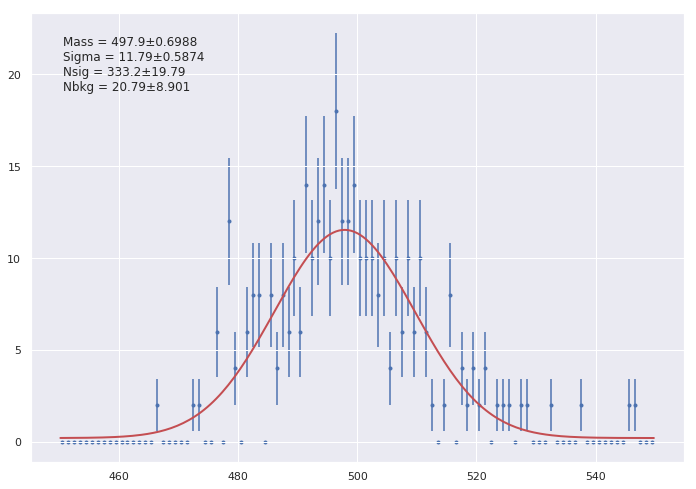

In [138]:
mt = fitter(dic[i], 100)
N_dic[i] = [mt.values[2], mt.errors[2]]
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dic[i]), 'Found:', mt.values[2] + mt.values[3] )

In [139]:
N_dic

{550.0: [1716.3374009671568, 43.468115310545414],
 562.5: [1497.1983845684101, 40.994164073643084],
 575.0: [1312.6882542283452, 37.48670601970873],
 587.5: [1228.3653922168544, 36.667342604016746],
 600.0: [1061.3542253209891, 33.6433929883147],
 612.5: [925.0036002065558, 32.45456885091952],
 625.0: [793.8168099975501, 29.37203939204026],
 637.5: [1570.3258568295073, 41.14112842182084],
 650.0: [700.9349677614883, 27.726471642629836],
 662.5: [662.490167044045, 26.939368585993154],
 675.0: [644.9929862583699, 27.14593092423745],
 687.5: [1188.8303333839567, 36.06750683000065],
 700.0: [638.2761592828687, 26.811694621605987],
 712.5: [605.9069249886311, 26.63306553315187],
 725.0: [1348.1774171995276, 39.23984038092027],
 737.5: [801.8496423191231, 29.71513405167146],
 750.0: [834.534353524565, 30.6249353207009],
 762.5: [2029.0025939455409, 48.710207160611965],
 775.0: [1078.762229797285, 34.91534120139207],
 787.5: [1269.3934161510408, 38.45473771376083],
 800.0: [1524.781885411579,

### Some notes:

11 { (600, 687.5, 725, 812.5) - only gauss,    (700, 737.5 : 20 bins; 880, 950 : 15 bins) }

12 { ( 910 :15 bins)}

17 { (725, 825, 880) - only gauss, (900 : 11 bins, 960 : 8 bins), 990 - govno }

In [ ]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [141]:
dataN = pd.DataFrame(N_dic)
dataN = dataN.T
dataN.columns = ['Nsig', 'dNsig']

In [142]:
dataN.head()

,Nsig,dNsig
550.0,1716.337401,43.468115
562.5,1497.198385,40.994164
575.0,1312.688254,37.486706
587.5,1228.365392,36.667343
600.0,1061.354225,33.643393


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [143]:
data_info = data.drop_duplicates(['lum']).drop(['m', 't'], axis=1)

In [144]:
dataN = dataN.join(data_info, how='inner')
dataN

,Nsig,dNsig,lum,Emean,dEmax,dEmin
550.0,1716.337401,43.468115,7163,550.0,0.0,0.0
562.5,1497.198385,40.994164,6306,562.5,0.0,0.0
575.0,1312.688254,37.486706,5516,575.0,0.0,0.0
587.5,1228.365392,36.667343,5116,587.5,0.0,0.0
600.0,1061.354225,33.643393,4606,600.0,0.0,0.0
612.5,925.003600,32.454569,4108,612.5,0.0,0.0
625.0,793.816810,29.372039,3799,625.0,0.0,0.0
637.5,1570.325857,41.141128,7066,637.5,0.0,0.0
650.0,700.934968,27.726472,3340,650.0,0.0,0.0
662.5,662.490167,26.939369,3172,662.5,0.0,0.0


OK, save it

In [145]:
dataN.to_csv('out'+year+'.csv', float_format='%.2f')

Ok, now about triggers

In [ ]:
triggers = data[['t']]
triggers['one'] = 1;

In [ ]:
triggers = pd.pivot_table(triggers, values='one', columns=['t'], index='label', aggfunc=np.sum).fillna(0)

In [ ]:
triggers.columns = ['TF', 'CF', 'TC']

In [ ]:
triggers.head()

In [ ]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [ ]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [ ]:
triggers.to_csv('triggers'+year+'.csv', float_format='%.2f')

In [ ]:
triggers